## Protein interaction
The genetic landscape of a physical interaction

In [8]:
import pandas as pd

df_1 = pd.read_excel("./data/protein_inter/GSE102901_TableS1.xlsx", sheet_name=None)
# df_2 = pd.read_excel("./data/protein_inter/GSE102901_TableS4.xlsx", sheet_name=None)

tmp = df_1["Sheet2"][["pos1", "mut1", "pos2", "mut2", "d_mean", "epi"]]
tmp["fos"] = tmp["pos1"].astype(str) + tmp["mut1"].astype(str)
tmp["jun"] = tmp["pos2"].astype(str) + tmp["mut2"].astype(str)

new_table = tmp[["fos", "jun", "epi"]]
new_table.to_csv("data/protein_inter/tables1_epi.csv", index=False, header=False)
new_table = tmp[["fos", "jun", "d_mean"]]
new_table.to_csv("data/protein_inter/tables1.csv", index=False, header=False)

/home/alexandre/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/alexandre/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/tmp/ipykernel_640453/888333702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp["fos"] = tmp["pos1"].astype(str) + tmp["mut1"].astype(str)
/tmp/ipykernel_640453/888333702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

## Without pearson spectral initialization 

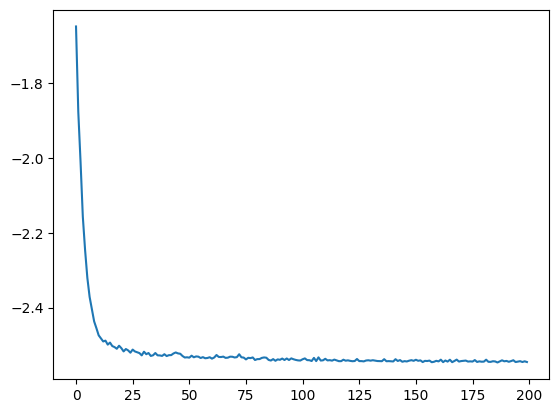

pearson 0.9358952749079006


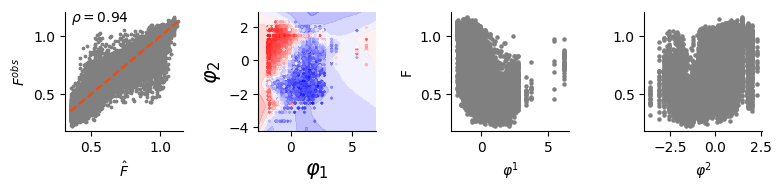

In [2]:
from dlim.model import DLIM
from dlim.utils import Data_model, train, spectral_init, compute_cor_scores
from numpy import mean, linspace, array, meshgrid, exp, diff, logical_and
from numpy.random import choice
import numpy as np
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import torch
data = Data_model("./data/protein_inter/tables1.csv", 2)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7), replace=False)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]
model = DLIM(data.nb_val, hid=128, nb_layer=2)

sim = "pearson"
model.spec_init_emb(train_data, data.mut_to_index, sim=sim)

losses = train(model, train_data, lr=1e-3, nb_epoch=200, bsize=256, wei_dec=1e-3, pen_emb=0)

plt.plot(losses)
plt.show()

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
fit_v, var, _ = model(train_data[:, :-1].long(), detach=True)
ax.scatter(fit_v, train_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit_v), max(fit_v), num=100)
y = linspace(min(fit_v), max(fit_v), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit_v.flatten(), train_data[:, [-1]].flatten())
print(sim, score)
# score = pearsonr(fit.flatten(), train_data[:, [-1]].flatten())[0]
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)
model.plot(bx, data=data, fontsize=15)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

# fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
# Plot the average curve
cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

plt.tight_layout()
# plt.savefig("../img/lenher_2.png", dpi=300, transparent=True)
plt.show()

# without spectralization 

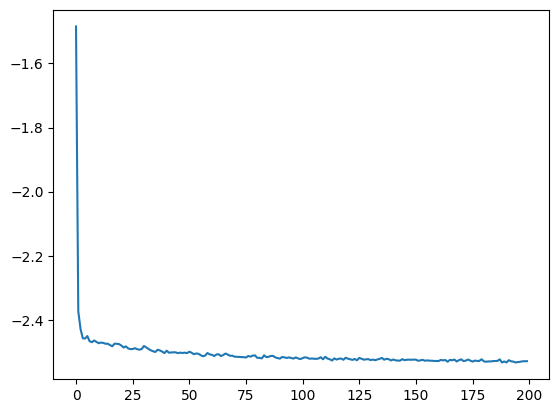

pearson 0.9316750684712669


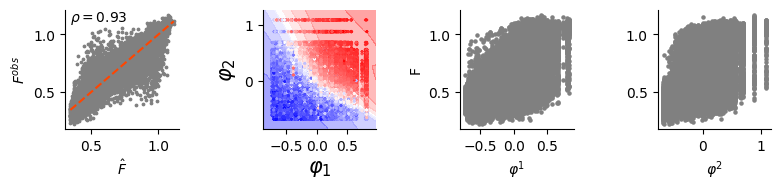

In [3]:
from dlim.model import DLIM
from dlim.utils import Data_model, train, spectral_init, compute_cor_scores
from numpy import mean, linspace, array, meshgrid, exp, diff, logical_and
from numpy.random import choice
import numpy as np
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import torch
data = Data_model("./data/protein_inter/tables1.csv", 2)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7), replace=False)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]
model = DLIM(data.nb_val, hid=128, nb_layer=2)

losses = train(model, train_data, lr=1e-3, nb_epoch=200, bsize=256, wei_dec=1e-6, pen_emb=0)

plt.plot(losses)
plt.show()

fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
fit_v, var, _ = model(train_data[:, :-1].long(), detach=True)
ax.scatter(fit_v, train_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit_v), max(fit_v), num=100)
y = linspace(min(fit_v), max(fit_v), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit_v.flatten(), train_data[:, [-1]].flatten())
print(sim, score)
# score = pearsonr(fit.flatten(), train_data[:, [-1]].flatten())[0]
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)
model.plot(bx, data=data, fontsize=15)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

# fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
# Plot the average curve/home/alexandre/Downloads/project/flux/D-LIM-model/img
cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

plt.tight_layout()
# plt.savefig("../img/lenher_2.png", dpi=300, transparent=True)
plt.show()

## Epistasis prediction 

In [ ]:
from dlim.model import DLIM
from dlim.utils import Data_model, train, spectral_init, compute_cor_scores
from numpy import mean, linspace, array, meshgrid, exp, diff, logical_and
from numpy.random import choice
import numpy as np
from torch import tensor, float32 as tfloat
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import torch
data = Data_model("./data/protein_inter/tables1_epi.csv", 2)
train_id = choice(range(data.data.shape[0]), int(data.data.shape[0]*0.7), replace=False)

train_data = data[train_id, :]
val_data = data[[i for i in range(data.data.shape[0]) if i not in train_id], :]
model = DLIM(data.nb_val, hid=128, nb_layer=2)

sim = "pearson"
model.spec_init_emb(train_data, data.mut_to_index, sim=sim)

losses = train(model, train_data, lr=1e-3, nb_epoch=200, bsize=256, wei_dec=1e-3, pen_emb=0)

plt.plot(losses)
plt.show()

pearson -5.892522633459489


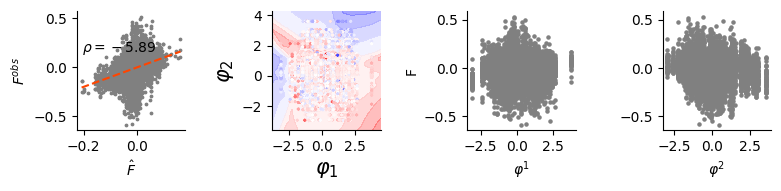

In [8]:
fig, (ax, bx, cx, dx) = plt.subplots(1, 4, figsize=(8, 2))
fit_v, var, _ = model(train_data[:, :-1].long(), detach=True)
ax.scatter(fit_v, train_data[:, [-1]], s=3, c="grey")
x = linspace(min(fit_v), max(fit_v), num=100)
y = linspace(min(fit_v), max(fit_v), num=100)
ax.plot(x, y, lw=1.5, linestyle="--", c="orangered")
ax.set_xlabel("$\\hat{F}$")
ax.set_ylabel("$F^{obs}$")
score = r2_score(fit_v.flatten(), train_data[:, [-1]].flatten())
print(sim, score)
# score = pearsonr(fit.flatten(), train_data[:, [-1]].flatten())[0]
ax.text(fit_v.min(), fit_v.max(), f"$\\rho={score:.2f}$")

fit, var, lat = model(data[:, :-1].long(), detach=True)
model.plot(bx, data=data, fontsize=15)

for el in ["top", "right"]:
    ax.spines[el].set_visible(False)
    bx.spines[el].set_visible(False)
    cx.spines[el].set_visible(False)
    dx.spines[el].set_visible(False)

# fig, (ax, bx) = plt.subplots(1, 2, figsize=(4, 2), sharey=True)
# Plot the average curve
cx.scatter(lat[:, 0], data[:, -1], s=5, c="grey")
dx.scatter(lat[:, 1], data[:, -1], s=5, c="grey")
cx.set_ylabel("F")
cx.set_xlabel("$\\varphi^1$")
dx.set_xlabel("$\\varphi^2$")

plt.tight_layout()
plt.savefig("./img/protein_epis_pearson.png", dpi=300, transparent=True)
plt.show()

# Check correlation

In [10]:
import pandas as pd 
df_1 = pd.read_excel("./data/protein_inter/GSE102901_TableS1.xlsx", sheet_name=None)


tmp = df_1["Sheet2"][["pos1", "mut1", "pos2", "mut2", "d_mean", "s1_mean", "s2_mean", "epi"]]


/home/alexandre/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)
/home/alexandre/miniconda3/envs/drug/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Text(0.5, 1.0, '0.582')

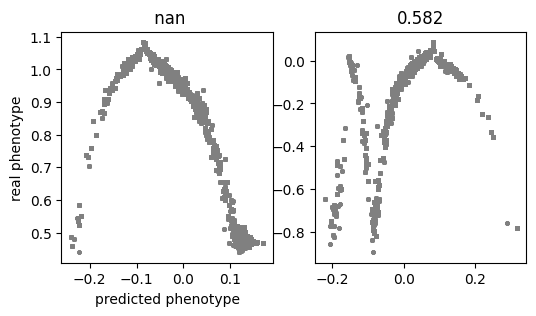

In [4]:
# check phenotype 
# check variance 
from scipy.stats import spearmanr
new_table = tmp[["s1_mean", "s2_mean", "epi", "d_mean"]]

figs, axes = plt.subplots(1, 2 , figsize = (6, 3))
sp = spearmanr(lat[:, 0], new_table['s1_mean'])[0]
axes[0].scatter(lat[:, 0], new_table['s1_mean'], s = 5, c= "grey")
axes[0].set_xlabel('predicted phenotype')
axes[0].set_ylabel('real phenotype')
axes[0].set_title(f'{sp: 0.3f}')
sp = spearmanr(lat[:, 1], np.log(new_table['s2_mean']))[0]
axes[1].scatter(lat[:, 1], np.log(new_table['s2_mean']), s = 5, c= "grey")
axes[1].set_title(f'{sp:0.3f}')